## MSR3 Reproducibility Guide

This notebook explains how to reproduce our results from [Sholokhov et. al. (2022): "A Relaxation Approach to Feature Selection for Linear Mixed Effects Models"](https://arxiv.org/abs/2205.06925?context=stat).

This repository only contains the code that uses [pysr3](https://github.com/aksholokhov/pysr3) library to produce figures and tables from the paper above. To learn more about pysr3 go here: [quickstart](https://github.com/aksholokhov/pysr3), [documentation](https://aksholokhov.github.io/pysr3/), [models overview](https://aksholokhov.github.io/pysr3/models_overview.html).

In our research group we take reproducibility seriously. Please open an issue in this repository if you can not reproduce our results with this notebook. We developed it using our current best knowledge on reproducibility which is imperfect and evolves as we receive more feedback.

## Installation

As of today, the code works with any version of python starting 3.8.11.

You need to install the following packages to your python environment to run this notebook:
  - pysr3>=0.3.4
  - pandas
  - dask
  - distributed
  - seaborn
  - pip
  - tqdm
  - rpy2

In [ ]:
# Uncomment the line below and execute the cell to install the packages above when you chose your dev environment
# !pip install dask distributed seaborn pip tqdm rpy2 pysr3>=0.3.4

Alternatively, you can use our *environment.yml* to create a new clean environment (**recommended**):

In [ ]:
# Uncomment the line below and execute the cell to create a new environment
# !conda env create -f environment.yml

## Usage

Most of the results can be replicated by running **generate_all.py** with different input parameters. Let's take a look at them:

In [ ]:
!python generate_all.py --help

For the reproducibility purposes the most important ones are:
- **experiment_name**: name for the current run. The script will create folders named 'results/experiment_name/{logs,figures,tables}' where it will place the resulting training logs, figures, and tables respectively.
- **experiments**: which experiments to run. List them as one string separated by commas, e.g. "L0,L1". Choices: intuition, L0, L1, ALASSO, SCAD, competitors, bullying
- **trials_from** and **trials_to**: how many synthetic problems do we use to compare the performance of our methods (for L0, L1, ALASSO, SCAD, and competitors)

### 1. Intuition picture (Figure 3)

This picture can be generated via the command below. It executes in a single-thread and takes about 5 minutes on my MacBook Pro 2019. The majority of this time is evaluating the values of the value function on a fine gid to draw the level-sets.

The code that executes this experiment is located in **intuition.py**

In [5]:
!python generate_all.py --experiments "intuition"

usage: competitors_table.py [-h] [--file_name FILE_NAME] [--ic IC]

optional arguments:
  -h, --help            show this help message and exit
  --file_name FILE_NAME
  --ic IC


The image outputs as a PDF. I use wand package for displaying it here. You can open the image manually if you don't want to install wand.

This is what I got:

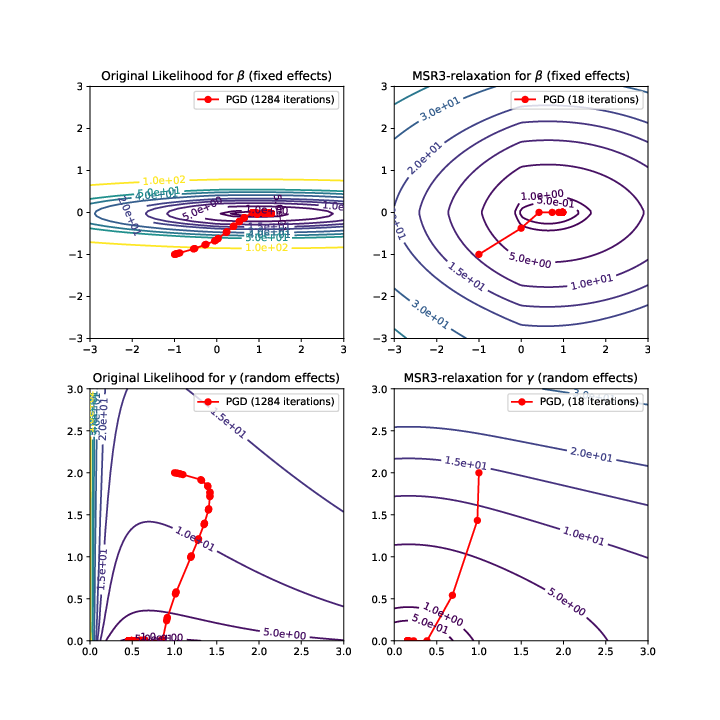

In [1]:
# To install wand on MacOS uncomment and execute two following lines:
#!brew install freetype imagemagick
#!pip install wand

from wand.image import Image as WImage
img = WImage (filename="results/local_debug_2023-03-21_12:09:29/figures/intuition_2023-03-21 12:21:04.531370.pdf")
img

### 2. Performance comparison

This experiment reproduces the Table 2 and Figure 4 from the paper. They compare the performance of PGD against MSR3 and MSR3-fast on a set of synthetic examples. In our paper we ran the experiments on 100 problems which took *240 CPU-hours* on our SLURM cluster. The main reason for why it takes so long is that the reference algorithms (PGD and MSR3) are quite slow: they need to be evaluated on a grid of 10 points for the regularization parameter $\lambda$, times another 10 points for the relaxation parameter $\eta$ for MSR3, all of that for 4 different regularizers (L0, L1, ALASSO, SCAD). With each of them taking 40 seconds on average they amount to (1+10)*10*4 = 300 minutes of CPU-time *per problem*, or trial. Our proposed algorithm MSR3-fast takes a tiny fraction (~1/400) of this time with its average execution time of 100 milliseconds.

Thus, your options are:
1. *Run it on a SLURM cluster (**preferred**)*: This is what we did. When running 100 problems in parallel the experiment took about 2 hours. You can use the provided file **run_on_slurm.bash** for it. Don't forget to adjust the username and the partition name to match your environment.
2. *Run it on a multicore computer with Dask*: 16 workers in parallel take about 20 hours to complete the experiments on my Intel Core i9-9980K.
3. *Run it on a smaller number of problems*: Running it for e.g. 3 problems won't probably give you the exact same numbers as we got in the paper due to larger variation, but it should be enough to see the overall pattern.
4. *Run only MSR3-fast*: It should be enough if you want to benchmark only our proposed algorithm. You'll need to edit *generate_all.py* for it.

**NB**: another big reason to run the code on SLURM is resource isolation per process.
- When you run your code in SLURM you ensure the execution time is measured correctly, as no other heavy processes are being executed in parallel.
- When you run your code on your local machine your processes interfere with the system processes and with each other. It introduces a time-dependent noise in your measurements that is hard to predict and is nearly impossible to get rid of. In past the system process could have been assumed brief and non-influential, but nowadays modern consumer PCs run heavy background processes such as photo processing, indexing, and caching, that could take multiple cores out of your resource pool and skew the measurements for one algorithm or all of them.

Here is what I got in about 1 hour of execution time for (3):

In [ ]:
!python generate_all.py --experiments "L0,L1,ALASSO,SCAD" --trials_from 1 --trials_to 3     # from is inclusive, to is exclusive

This run's input parameters are saved as: 
 results/local_debug/logs/experiment_inputs_1.pickle

Run comparison experiment for L0-based selection benchmark (Table 2, Figure 4). Problems to solve: [1, 3)
Jobs to process: 42
Processing with Dask.Distributed, with 15 workers in parallel.
33it [18:20, 171.50s/it]L0 did not converge for trial=2 param=3


### 3. Bullying example

In this example (Chapter 4.2, Figure 6) we apply our method to Bullying Data from GBD. The goal of the underlying study was to estimate the burden (DALYs) of major depressive disorder (MDD) and anxiety disorders that are caused by bullying.

- The dataset is located in *bullying/bullying_data.csv*
- The code that executes the experiments and produces plots is located in *bullying/bullying_example.py*

The experiment runs quickly (~2s) on a single-core machine. This is how you run it:

In [7]:
!python generate_all.py --experiments "bullying"

This run's input parameters are saved as: 
 /Users/aksh/Storage/repos/msr3-paper/results/local_debug/logs/experiment_inputs_1.pickle
Run a feature-selection experiment on real-world data from the Bullying study. (Figure 6)
Figure(600x600)
100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 14.38it/s]
Random feature selection saved as as results/local_debug/figures/bullying_data_random_feature_selection_2023-03-21 13:12:53.527993.pdf
Random feature selection saved as as results/local_debug/figures/bullying_data_random_feature_selection_2023-03-21 13:12:53.527993.pdf
Assessment saved as as results/local_debug/figures/bullying_data_assessment_selection_2023-03-21 13:12:53.527993.pdf


Here is what I got:

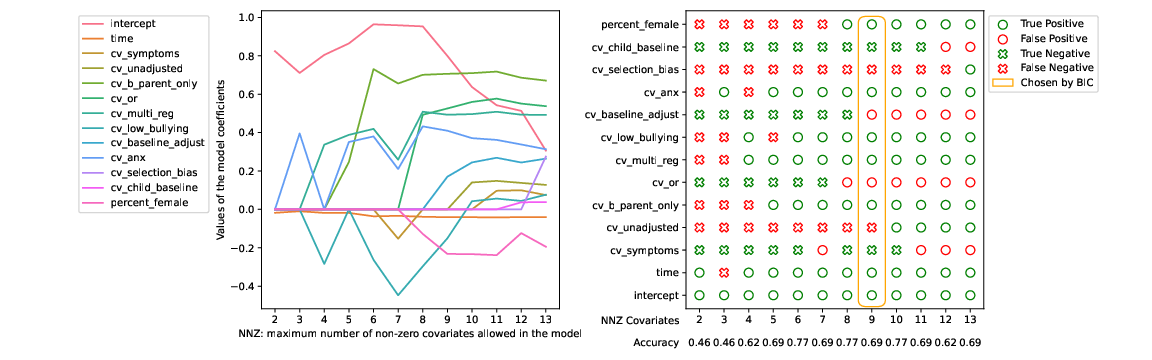

In [8]:
from wand.image import Image as WImage
img = WImage (filename="results/local_debug/figures/bullying_data_assessment_selection_2023-03-21 13:12:53.527993.pdf")
img

### 4. Comparison with Alternative libraries

We provide python wrappers for four R libraries: **[fence](https://cran.r-project.org/web/packages/fence/index.html)**, **[lmmlasso](https://rdrr.io/cran/lmmlasso/)**, **[glmmlasso](https://cran.r-project.org/web/packages/glmmLasso/index.html)**, and **[pco](https://pubmed.ncbi.nlm.nih.gov/24920875/)** (see in *alterntatives/pco.r*). Each wrapper consists of two files
- *alternatives/name.r*: an R code that runs the library *name* to the provided dataset
- *alternatives/name_wrapper.py* a python code that links the R file above to our experimental pipeline


To run then within our experimental pipeline you need:
- Make sure that you have an R environment installed with the paths to it appropriately linked to the system.
- Install the R packages for the algorithms from the list above.
- Install rpy2 library to your python environment.

As discussed  in the paper, we only report the evaluations for lmmlasso and glmmlasso because
- PCO can not solve problems where the number of random effects (|gamma| * num_groups) exceeds the total number of objects, which is the case for our problem set.
- Fence is too slow and runs out of memory on Macbook Pro 16 with 32GB of RAM.

Nevertheless, we provide the wrappers for all four libraries. If you want to give PCO and Fence another go then you need to uncomment them in the lines 385-390 of *generate_all.py*

Here is how you can launch it:

In [ ]:
!python generate_all.py --experiments "competitors" --trials_from 1 --trials_to 2     # from is inclusive, to is exclusive

Here is what I got for running it on just one problem:

In [1]:
import pandas as pd
alternatives = pd.read_csv('results/local_debug/tables/competitors_table_long_competitors_0.log.csv')
alternatives

,Unnamed: 0,SR3-L1-P,glmmLasso,lmmLasso
0,Accuracy,95 (95-95),45 (45-45),72 (72-72)
1,FE Accuracy,95 (95-95),45 (45-45),45 (45-45)
2,RE Accuracy,95 (95-95),45 (45-45),100 (100-100)
3,F1,94 (94-94),61 (61-61),77 (77-77)
4,FE F1,95 (95-95),59 (59-59),62 (62-62)
5,RE F1,94 (94-94),62 (62-62),100 (100-100)
6,Time,0.24 (0.24-0.24),0.72 (0.72-0.72),8.14 (8.14-8.14)
7,Iterations,90 (90-90),53 (53-53),0 (0-0)
